## Topic Modeling: probabilistic LSA / Non-negative Matrix Factorization

### Imports

In [6]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [10]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [11]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [12]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [32]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [33]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [34]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
entertainment     9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [35]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [36]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

## probabilistic Latent Semantic Analysis

### Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

In [43]:
nmf = NMF(n_components=5, random_state=42, solver='mu',
          beta_loss='kullback-leibler', max_iter=1000)
nmf.fit(train_dtm)
nmf.reconstruction_err_

1168.6761144034633

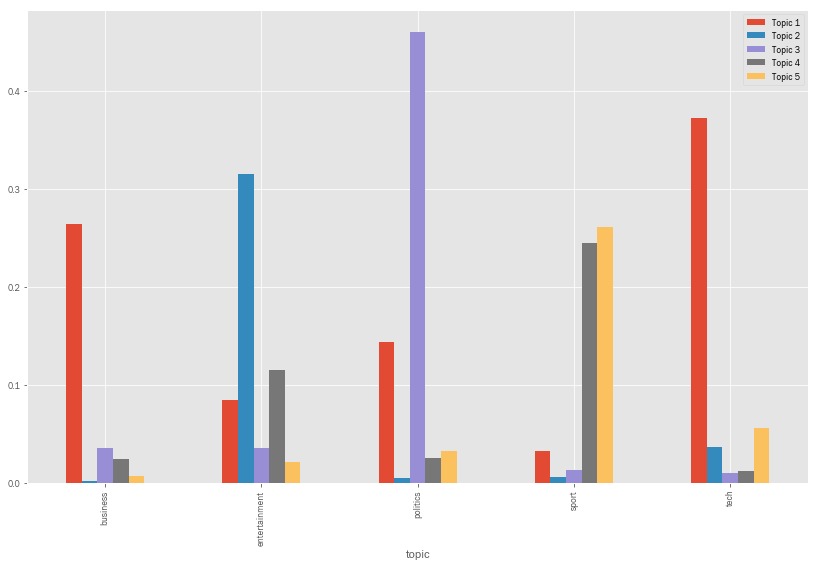

In [44]:
nmf_res = pd.DataFrame(data=nmf.transform(train_dtm),
                       columns=topic_labels,
                       index=train_docs.topic)
nmf_res.groupby(level='topic').mean().plot.bar();

In [45]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,1.02,0.00,0.00,0.72,0.00
100,0.51,0.00,0.00,0.00,0.00
100m,0.03,0.00,0.00,0.21,0.00
11,0.39,0.00,0.00,0.44,0.00
12,0.48,0.00,0.00,0.50,0.00


In [46]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,market,film,labour,second,game
1,company,best,election,final,england
2,says,music,party,won,games
3,work,awards,blair,win,play
4,use,award,minister,france,players
5,million,won,brown,open,wales
6,firm,band,public,best,club
7,2004,actor,howard,old,good
8,technology,director,britain,ireland,think
9,mobile,album,prime,international,half


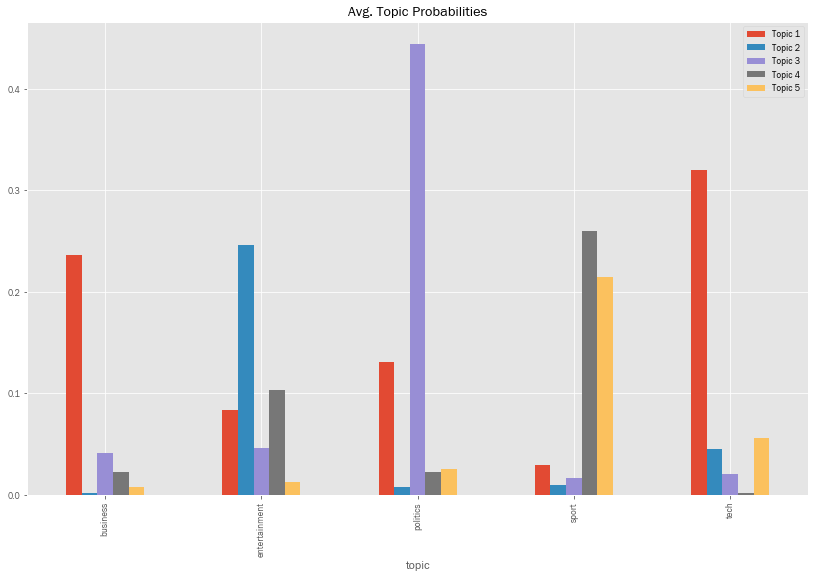

In [47]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(
    title='Avg. Topic Probabilities');